# NOTEBOOK 03: MODEL TRAINING AND EVALUATION
## Credit Risk Early Warning System

**OBJECTIVES:**
1. Prepare data for modeling (train/test split, handle categoricals)
2. Train XGBoost classifier for credit default prediction
3. Evaluate using banking-relevant metrics (AUC, Gini, precision/recall)
4. Optimize classification threshold for business objectives
5. Analyze feature importance
6. Save model for deployment

**KEY BANKING CONTEXT:**
- We're predicting Probability of Default (PD) — a core component of Expected Loss
- False Negatives (approving bad loans) cost more than False Positives (rejecting good loans)
- Model must be explainable for regulatory compliance

# 1. Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
import gc

# Scikit-learn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score,
    average_precision_score
)

# XGBoost
import xgboost as xgb

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

# Define paths
PROJECT_ROOT = Path.cwd().parent
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
MODELS_PATH = PROJECT_ROOT / 'models'
REPORTS_PATH = PROJECT_ROOT / 'reports'

# Create models directory if it doesn't exist
MODELS_PATH.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print("✅ Libraries imported successfully")

Project root: c:\Users\carlo\Documents\4.DS\credit-risk-early-warning-system
✅ Libraries imported successfully


In [2]:
# Load the engineered features
print("Loading engineered features...")
df = pd.read_csv(DATA_PROCESSED / 'features_train.csv')
print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Quick check of target distribution
print(f"\nTarget distribution:")
print(df['TARGET'].value_counts())
print(f"\nDefault rate: {df['TARGET'].mean()*100:.2f}%")

Loading engineered features...
Dataset loaded: 307,511 rows × 213 columns

Target distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64

Default rate: 8.07%


# 2. Data Preparation for Modeling

Before training, we need to:
1. Separate features (X) from target (y)
2. Handle categorical variables (XGBoost needs numeric input)
3. Split into training and test sets (stratified to preserve class balance)
4. Address class imbalance

In [3]:
# =============================================================================
# 2.1 SEPARATE FEATURES AND TARGET
# =============================================================================

# Columns to exclude from features
exclude_cols = ['SK_ID_CURR', 'TARGET']

# Define feature columns
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Total features: {len(feature_cols)}")

# Create X and y
X = df[feature_cols].copy()
y = df['TARGET'].copy()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"y distribution:\n{y.value_counts(normalize=True)}")

Total features: 211
X shape: (307511, 211)
y shape: (307511,)
y distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


In [4]:
# =============================================================================
# 2.2 HANDLE CATEGORICAL VARIABLES
# =============================================================================

# Find categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns to encode: {len(categorical_cols)}")
print(categorical_cols)

# Label encode categorical variables
# (XGBoost can handle label-encoded categoricals well)
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Handle NaN by converting to string first
    X[col] = X[col].astype(str)
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    
print(f"\n✅ Encoded {len(categorical_cols)} categorical columns")

# Verify all columns are now numeric
print(f"Data types after encoding:")
print(X.dtypes.value_counts())

Categorical columns to encode: 16
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

✅ Encoded 16 categorical columns
Data types after encoding:
float64    153
int64       58
Name: count, dtype: int64


In [8]:
X.head(3)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,...,PREV_AMT_CREDIT_SUM,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MIN,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CREDIT_TO_APPLICATION_RATIO,PREV_AVG_CREDIT_PER_APP,PREV_STATUS_APPROVED,PREV_STATUS_CANCELED,PREV_STATUS_REFUSED,PREV_STATUS_UNUSED_OFFER,PREV_APPROVAL_RATE,PREV_REFUSAL_RATE,PREV_CONTRACT_CASH_LOANS,PREV_CONTRACT_CONSUMER_LOANS,PREV_CONTRACT_REVOLVING_LOANS,PREV_CONTRACT_XNA
0,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,6,7,4,3,1,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,...,179055.0,179055.0,179055.0,179055.0,9251.775,9251.775,0.0,0.0,-606.0,-606.0,-606.0,24.0,24.0,1.000000,179055.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,...,1452573.0,484191.0,1035882.0,68053.5,56553.990,98356.995,6885.0,3442.5,-2341.0,-746.0,-1305.0,10.0,30.0,1.111967,484191.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0
2,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,6,7,4,3,1,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,...,20106.0,20106.0,20106.0,20106.0,5357.250,5357.250,4860.0,4860.0,-815.0,-815.0,-815.0,4.0,4.0,0.828021,20106.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [9]:
# =============================================================================
# 2.3 TRAIN/TEST SPLIT (STRATIFIED)
# =============================================================================

# Stratified split ensures both train and test have ~8% default rate
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 80% train, 20% test
    random_state=42,         # Reproducibility
    stratify=y               # Maintain class balance!
)

print("Train/Test Split (Stratified):")
print(f"  X_train: {X_train.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"\nDefault rates preserved:")
print(f"  Train default rate: {y_train.mean()*100:.2f}%")
print(f"  Test default rate:  {y_test.mean()*100:.2f}%")

Train/Test Split (Stratified):
  X_train: (246008, 211)
  X_test:  (61503, 211)

Default rates preserved:
  Train default rate: 8.07%
  Test default rate:  8.07%


In [10]:
# =============================================================================
# 2.4 CALCULATE CLASS WEIGHT FOR IMBALANCE
# =============================================================================

# For imbalanced data, we adjust the weight of the minority class
# scale_pos_weight = number of negative cases / number of positive cases

n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive

print("Class Imbalance Handling:")
print(f"  Non-default (0): {n_negative:,}")
print(f"  Default (1):     {n_positive:,}")
print(f"  Ratio:           {n_negative/n_positive:.1f}:1")
print(f"  scale_pos_weight: {scale_pos_weight:.2f}")
print("\nThis tells XGBoost to weight default cases ~11x more heavily")

Class Imbalance Handling:
  Non-default (0): 226,148
  Default (1):     19,860
  Ratio:           11.4:1
  scale_pos_weight: 11.39

This tells XGBoost to weight default cases ~11x more heavily


# 3. Train XGBoost Model

XGBoost (eXtreme Gradient Boosting) is the industry standard for credit risk modeling because:
- Handles missing values natively
- Works well with mixed feature types
- Provides feature importance
- Fast training and prediction
- Excellent performance on tabular data

We'll start with a baseline model, then tune hyperparameters.

In [11]:
# =============================================================================
# 3.1 BASELINE XGBOOST MODEL
# =============================================================================

print("Training baseline XGBoost model...")

# Define baseline parameters
baseline_params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'auc',            # Optimize for AUC
    'scale_pos_weight': scale_pos_weight,  # Handle imbalance
    'max_depth': 5,                  # Prevent overfitting
    'learning_rate': 0.1,            # Step size
    'n_estimators': 200,             # Number of trees
    'subsample': 0.8,                # Row sampling
    'colsample_bytree': 0.8,         # Column sampling
    'random_state': 42,
    'n_jobs': -1,                    # Use all CPU cores
    'verbosity': 0
}

# Train model
model_baseline = xgb.XGBClassifier(**baseline_params)
model_baseline.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

print("✅ Baseline model trained")

Training baseline XGBoost model...
✅ Baseline model trained


In [12]:
# =============================================================================
# 3.2 BASELINE MODEL EVALUATION
# =============================================================================

# Get predictions
y_pred_proba = model_baseline.predict_proba(X_test)[:, 1]  # Probability of default
y_pred = model_baseline.predict(X_test)  # Binary prediction (threshold 0.5)

# Calculate metrics
auc_score = roc_auc_score(y_test, y_pred_proba)
gini = 2 * auc_score - 1  # Banking standard metric

print("=" * 60)
print("BASELINE MODEL PERFORMANCE")
print("=" * 60)
print(f"\n📊 Key Metrics:")
print(f"   AUC-ROC:  {auc_score:.4f}")
print(f"   Gini:     {gini:.4f}")
print(f"\n📋 Classification Report (threshold=0.5):")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

BASELINE MODEL PERFORMANCE

📊 Key Metrics:
   AUC-ROC:  0.7793
   Gini:     0.5585

📋 Classification Report (threshold=0.5):
              precision    recall  f1-score   support

  No Default       0.96      0.74      0.84     56538
     Default       0.19      0.67      0.29      4965

    accuracy                           0.74     61503
   macro avg       0.57      0.71      0.57     61503
weighted avg       0.90      0.74      0.79     61503



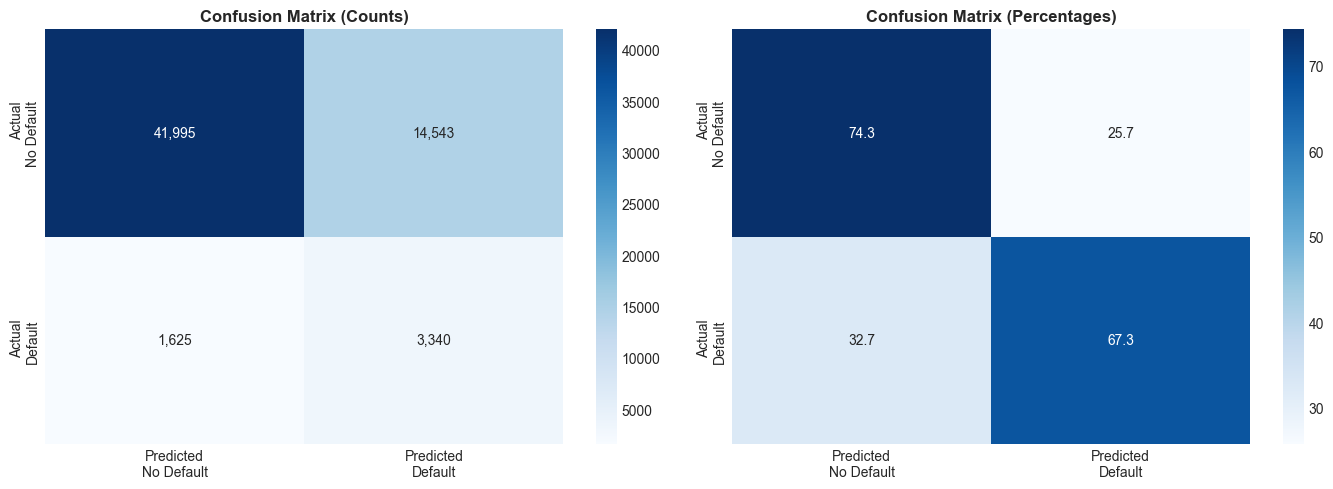


🔍 Interpretation:
   True Negatives (correctly approved):  41,995
   False Positives (wrongly rejected):   14,543
   False Negatives (wrongly approved):   1,625 ⚠️ COSTLY!
   True Positives (correctly rejected):  3,340


In [13]:
# =============================================================================
# 3.3 CONFUSION MATRIX VISUALIZATION
# =============================================================================

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Confusion Matrix (counts)
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', ax=axes[0],
            xticklabels=['Predicted\nNo Default', 'Predicted\nDefault'],
            yticklabels=['Actual\nNo Default', 'Actual\nDefault'])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=12, fontweight='bold')

# Plot 2: Confusion Matrix (percentages)
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues', ax=axes[1],
            xticklabels=['Predicted\nNo Default', 'Predicted\nDefault'],
            yticklabels=['Actual\nNo Default', 'Actual\nDefault'])
axes[1].set_title('Confusion Matrix (Percentages)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(REPORTS_PATH / 'confusion_matrix_baseline.png', dpi=150, bbox_inches='tight')
plt.show()

# Interpret results
tn, fp, fn, tp = cm.ravel()
print(f"\n🔍 Interpretation:")
print(f"   True Negatives (correctly approved):  {tn:,}")
print(f"   False Positives (wrongly rejected):   {fp:,}")
print(f"   False Negatives (wrongly approved):   {fn:,} ⚠️ COSTLY!")
print(f"   True Positives (correctly rejected):  {tp:,}")

# 4. Cross-Validation for Robust Evaluation

A single train/test split can be misleading. Cross-validation gives us a more reliable estimate of model performance by training and testing on multiple different splits.

In [14]:
# =============================================================================
# 4.1 STRATIFIED K-FOLD CROSS-VALIDATION
# =============================================================================

print("Running 5-Fold Stratified Cross-Validation...")

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(
    model_baseline, X, y,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

print("\n" + "=" * 60)
print("CROSS-VALIDATION RESULTS")
print("=" * 60)
print(f"\nAUC scores for each fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"   Fold {i}: {score:.4f}")

print(f"\n📊 Summary:")
print(f"   Mean AUC:  {cv_scores.mean():.4f}")
print(f"   Std Dev:   {cv_scores.std():.4f}")
print(f"   Gini:      {2*cv_scores.mean()-1:.4f}")

print(f"\n✅ Model performance is consistent across folds (low std dev = stable model)")

Running 5-Fold Stratified Cross-Validation...

CROSS-VALIDATION RESULTS

AUC scores for each fold:
   Fold 1: 0.7724
   Fold 2: 0.7804
   Fold 3: 0.7735
   Fold 4: 0.7800
   Fold 5: 0.7723

📊 Summary:
   Mean AUC:  0.7757
   Std Dev:   0.0037
   Gini:      0.5515

✅ Model performance is consistent across folds (low std dev = stable model)


# 5. Threshold Optimization

The default threshold of 0.5 is rarely optimal for credit risk. We need to find the threshold that balances:
- **Precision**: Of those we reject, how many were actually bad? (Avoid rejecting good customers)
- **Recall**: Of all bad loans, how many did we catch? (Avoid approving bad loans)

In banking, we often care more about recall (catching defaults) because the cost of a default exceeds the cost of losing a good customer.

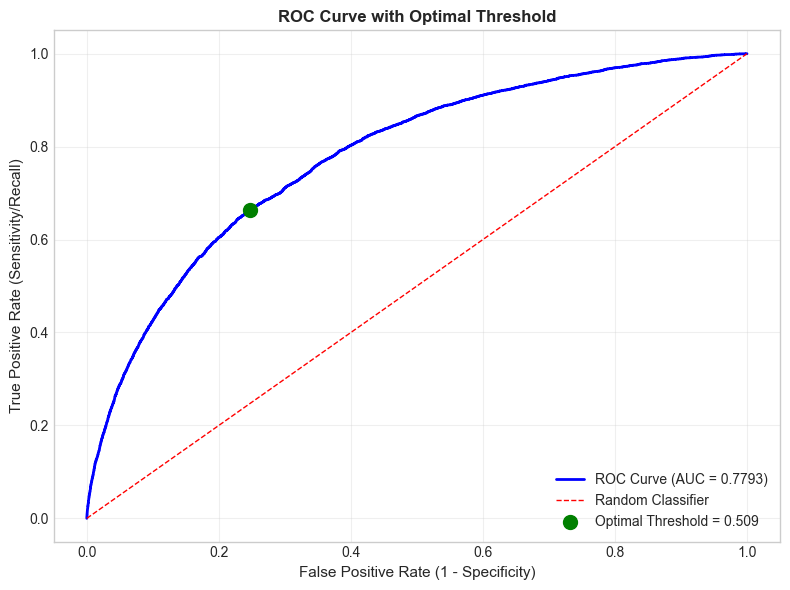

📍 Optimal Threshold (Youden's J): 0.5092
   At this threshold:
   - True Positive Rate (Recall): 0.6638
   - False Positive Rate:         0.2474


In [ ]:
# Cell 11
# =============================================================================
# 5.1 ROC CURVE AND OPTIMAL THRESHOLD
# =============================================================================

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)

# Find optimal threshold using Youden's J statistic
# J = Sensitivity + Specificity - 1 = TPR - FPR
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold_youden = thresholds_roc[optimal_idx]

# Plot ROC curve
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
ax.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Classifier')
ax.scatter(fpr[optimal_idx], tpr[optimal_idx], c='green', s=100, zorder=5,
           label=f'Optimal Threshold = {optimal_threshold_youden:.3f}')

ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=11)
ax.set_ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=11)
ax.set_title('ROC Curve with Optimal Threshold', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_PATH / 'roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"📍 Optimal Threshold (Youden's J): {optimal_threshold_youden:.4f}")
print(f"   At this threshold:")
print(f"   - True Positive Rate (Recall): {tpr[optimal_idx]:.4f}")
print(f"   - False Positive Rate:         {fpr[optimal_idx]:.4f}")

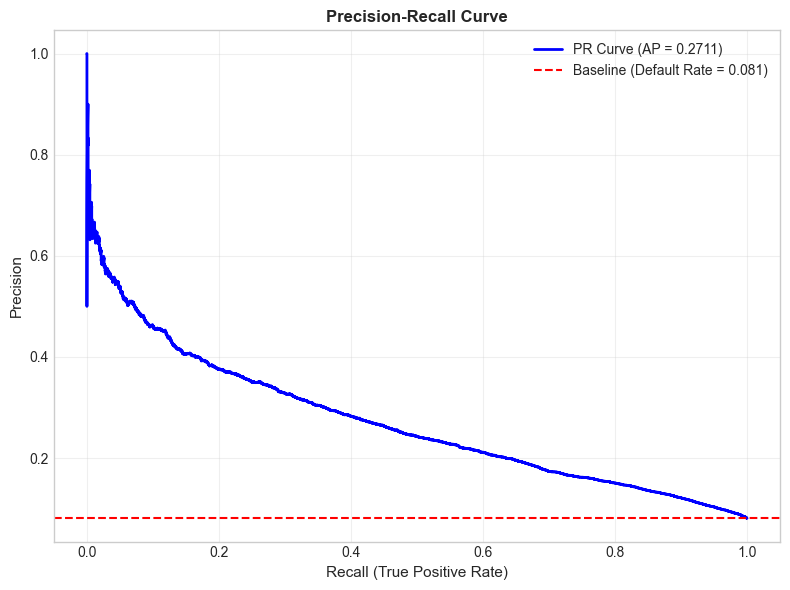

📊 Average Precision Score: 0.2711


In [17]:
# Code cell 12
# =============================================================================
# 5.2 PRECISION-RECALL CURVE
# =============================================================================

# Calculate precision-recall curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

# Plot precision-recall curve
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(recall_curve, precision_curve, 'b-', linewidth=2, 
        label=f'PR Curve (AP = {avg_precision:.4f})')
ax.axhline(y=y_test.mean(), color='r', linestyle='--', 
           label=f'Baseline (Default Rate = {y_test.mean():.3f})')

ax.set_xlabel('Recall (True Positive Rate)', fontsize=11)
ax.set_ylabel('Precision', fontsize=11)
ax.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_PATH / 'precision_recall_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"📊 Average Precision Score: {avg_precision:.4f}")

In [18]:
# Code cell 13
# =============================================================================
# 5.3 THRESHOLD ANALYSIS TABLE
# =============================================================================

# Analyze metrics at different thresholds
thresholds_to_analyze = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6]

print("=" * 80)
print("THRESHOLD ANALYSIS")
print("=" * 80)
print(f"\n{'Threshold':>10} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Rejected%':>12}")
print("-" * 55)

threshold_results = []

for thresh in thresholds_to_analyze:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    rejected_pct = y_pred_thresh.mean() * 100
    
    print(f"{thresh:>10.2f} {prec:>10.4f} {rec:>10.4f} {f1:>10.4f} {rejected_pct:>11.1f}%")
    
    threshold_results.append({
        'threshold': thresh,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'rejected_pct': rejected_pct
    })

threshold_df = pd.DataFrame(threshold_results)

THRESHOLD ANALYSIS

 Threshold  Precision     Recall         F1    Rejected%
-------------------------------------------------------
      0.10     0.0864     0.9919     0.1590        92.6%
      0.15     0.0934     0.9754     0.1705        84.3%
      0.20     0.1024     0.9529     0.1849        75.1%
      0.25     0.1131     0.9219     0.2014        65.8%
      0.30     0.1253     0.8884     0.2196        57.2%
      0.35     0.1381     0.8431     0.2373        49.3%
      0.40     0.1529     0.7921     0.2564        41.8%
      0.50     0.1868     0.6727     0.2924        29.1%
      0.60     0.2321     0.5392     0.3245        18.8%


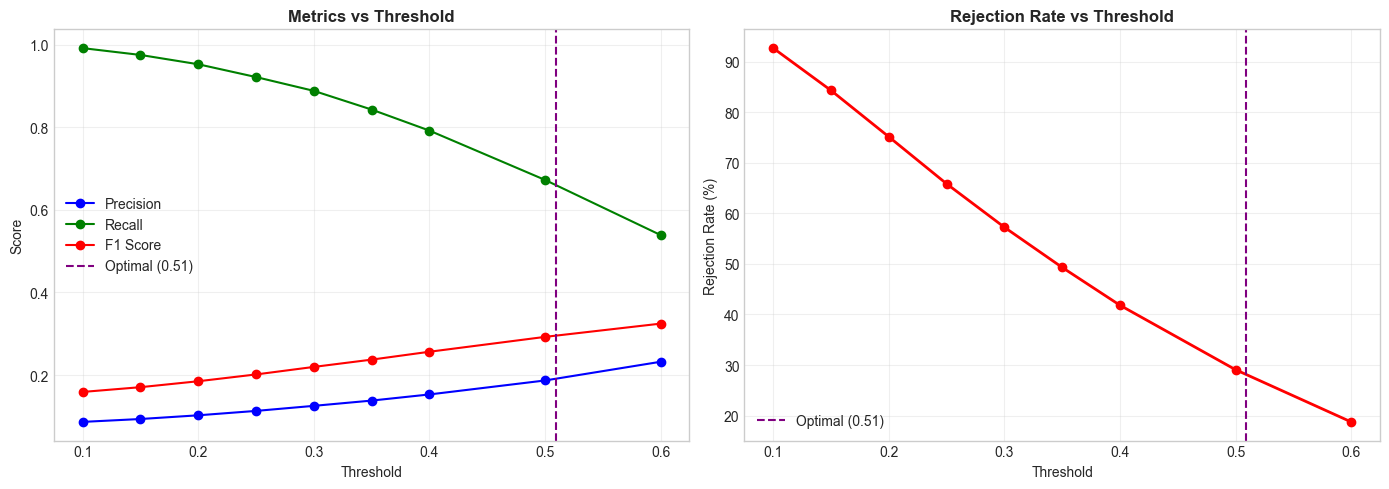


💡 INSIGHT: Lower threshold = more rejections = catch more defaults but lose more good customers


In [19]:
# Code cell 14
# =============================================================================
# 5.4 VISUALIZE THRESHOLD TRADEOFFS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision, Recall, F1 vs Threshold
ax1 = axes[0]
ax1.plot(threshold_df['threshold'], threshold_df['precision'], 'b-o', label='Precision')
ax1.plot(threshold_df['threshold'], threshold_df['recall'], 'g-o', label='Recall')
ax1.plot(threshold_df['threshold'], threshold_df['f1'], 'r-o', label='F1 Score')
ax1.axvline(x=optimal_threshold_youden, color='purple', linestyle='--', 
            label=f'Optimal ({optimal_threshold_youden:.2f})')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Metrics vs Threshold', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Rejection Rate vs Threshold
ax2 = axes[1]
ax2.plot(threshold_df['threshold'], threshold_df['rejected_pct'], 'r-o', linewidth=2)
ax2.axvline(x=optimal_threshold_youden, color='purple', linestyle='--', 
            label=f'Optimal ({optimal_threshold_youden:.2f})')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Rejection Rate (%)')
ax2.set_title('Rejection Rate vs Threshold', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_PATH / 'threshold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHT: Lower threshold = more rejections = catch more defaults but lose more good customers")

# 6. Business Cost Analysis (Differentiator!)

This is what separates a portfolio project from a production model. We calculate the expected financial impact of different thresholds.

**Assumptions (simplified):**
- Average loan amount: $15,000
- Loss Given Default (LGD): 60% (bank recovers 40%)
- Profit per good loan approved: 10% of loan = $1,500
- Cost per rejected good customer: Lost profit = $1,500
- Cost per approved bad loan: LGD × Loan = $9,000

In [20]:
# Code cell 15
# =============================================================================
# 6.1 COST-SENSITIVE EVALUATION
# =============================================================================

# Business parameters (can be adjusted)
LOAN_AMOUNT = 15000
LGD = 0.60  # Loss Given Default
PROFIT_RATE = 0.10  # Profit margin on good loans

# Calculate costs
COST_DEFAULT = LOAN_AMOUNT * LGD  # Cost of approving a defaulter
PROFIT_GOOD_LOAN = LOAN_AMOUNT * PROFIT_RATE  # Profit from good loan

print("=" * 60)
print("BUSINESS COST PARAMETERS")
print("=" * 60)
print(f"Average loan amount:     ${LOAN_AMOUNT:,.0f}")
print(f"Loss Given Default:      {LGD*100:.0f}%")
print(f"Cost of default:         ${COST_DEFAULT:,.0f}")
print(f"Profit per good loan:    ${PROFIT_GOOD_LOAN:,.0f}")

BUSINESS COST PARAMETERS
Average loan amount:     $15,000
Loss Given Default:      60%
Cost of default:         $9,000
Profit per good loan:    $1,500


In [ ]:
# Code cell 16
# =============================================================================
# 6.2 CALCULATE EXPECTED PROFII have the intuitionT FOR DIFFERENT THRESHOLDS
# =============================================================================

def calculate_expected_profit(y_true, y_pred_proba, threshold, 
                              cost_default=COST_DEFAULT, profit_good=PROFIT_GOOD_LOAN):
    """
    Calculate expected profit/loss for a given threshold.
    
    Approved loans:
    - Good customer (TN): Earn profit
    - Bad customer (FN): Lose cost_default
    
    Rejected loans:
    - Good customer (FP): Lost profit opportunity
    - Bad customer (TP): Avoided loss (neutral, $0)
    """
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate profit components
    profit_from_approved_good = tn * profit_good  # Good customers we approved
    loss_from_approved_bad = fn * cost_default     # Bad customers we approved
    lost_opportunity = fp * profit_good            # Good customers we rejected
    avoided_loss = tp * cost_default               # Bad customers we rejected
    
    # Net profit
    net_profit = profit_from_approved_good - loss_from_approved_bad - lost_opportunity
    
    return {
        'threshold': threshold,
        'net_profit': net_profit,
        'profit_approved_good': profit_from_approved_good,
        'loss_approved_bad': loss_from_approved_bad,
        'lost_opportunity': lost_opportunity,
        'avoided_loss': avoided_loss,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    }

# Calculate for multiple thresholds
profit_results = []
for thresh in np.arange(0.05, 0.60, 0.02):
    result = calculate_expected_profit(y_test, y_pred_proba, thresh)
    profit_results.append(result)

profit_df = pd.DataFrame(profit_results)

# Find optimal business threshold
optimal_profit_idx = profit_df['net_profit'].idxmax()
optimal_threshold_business = profit_df.loc[optimal_profit_idx, 'threshold']
max_profit = profit_df.loc[optimal_profit_idx, 'net_profit']

print("\n" + "=" * 60)
print("BUSINESS OPTIMIZATION RESULTS")
print("=" * 60)
print(f"\n💰 Optimal Business Threshold: {optimal_threshold_business:.2f}")
print(f"   Maximum Expected Profit:    ${max_profit:,.0f}")


BUSINESS OPTIMIZATION RESULTS

💰 Optimal Business Threshold: 0.59
   Maximum Expected Profit:    $36,819,000


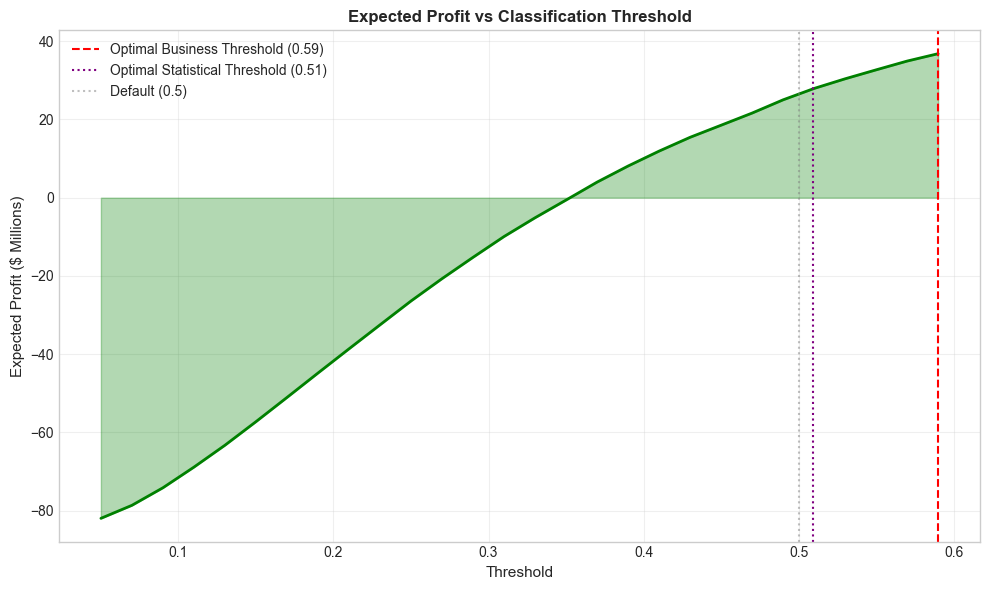

💡 INSIGHT: Statistical optimal (Youden) and business optimal thresholds may differ!
   A risk manager would choose based on the bank's risk appetite and business goals.


In [22]:
# code cell 17
# =============================================================================
# 6.3 VISUALIZE PROFIT VS THRESHOLD
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(profit_df['threshold'], profit_df['net_profit'] / 1e6, 'g-', linewidth=2)
ax.axvline(x=optimal_threshold_business, color='red', linestyle='--', 
           label=f'Optimal Business Threshold ({optimal_threshold_business:.2f})')
ax.axvline(x=optimal_threshold_youden, color='purple', linestyle=':', 
           label=f'Optimal Statistical Threshold ({optimal_threshold_youden:.2f})')
ax.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5, label='Default (0.5)')

ax.fill_between(profit_df['threshold'], profit_df['net_profit'] / 1e6, 
                alpha=0.3, color='green')

ax.set_xlabel('Threshold', fontsize=11)
ax.set_ylabel('Expected Profit ($ Millions)', fontsize=11)
ax.set_title('Expected Profit vs Classification Threshold', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_PATH / 'profit_vs_threshold.png', dpi=150, bbox_inches='tight')
plt.show()

print("💡 INSIGHT: Statistical optimal (Youden) and business optimal thresholds may differ!")
print("   A risk manager would choose based on the bank's risk appetite and business goals.")

# 7. Feature Importance Analysis

Understanding which features drive predictions is crucial for:
1. **Regulatory compliance**: Explaining why loans are approved/rejected
2. **Business insights**: Understanding what drives credit risk
3. **Model debugging**: Ensuring the model uses sensible features

In [23]:
# code cell 18
# =============================================================================
# 7.1 XGBOOST FEATURE IMPORTANCE
# =============================================================================

# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_baseline.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 20
print("=" * 60)
print("TOP 20 MOST IMPORTANT FEATURES")
print("=" * 60)
print(importance_df.head(20).to_string(index=False))

# Save full importance list
importance_df.to_csv(DATA_PROCESSED / 'feature_importance.csv', index=False)
print(f"\n✅ Full feature importance saved to data/processed/feature_importance.csv")

TOP 20 MOST IMPORTANT FEATURES
                          feature  importance
                  EXT_SOURCE_MEAN    0.077107
                   EXT_SOURCE_MAX    0.038003
              NAME_EDUCATION_TYPE    0.017366
                   EXT_SOURCE_MIN    0.016061
                      CODE_GENDER    0.014057
                   FLAG_EMP_PHONE    0.013407
                  CREDIT_TO_GOODS    0.012650
                PREV_REFUSAL_RATE    0.011794
               EXT_SOURCE_PRODUCT    0.011063
                 NAME_INCOME_TYPE    0.010575
         DOCUMENTS_PROVIDED_RATIO    0.010479
                  FLAG_DOCUMENT_3    0.010011
         DOCUMENTS_PROVIDED_COUNT    0.009166
                        AGE_YEARS    0.008677
            BUREAU_TYPE_MICROLOAN    0.008629
BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX    0.008626
        PREV_AMT_DOWN_PAYMENT_SUM    0.008612
                ANNUITY_TO_CREDIT    0.008488
                     EXT_SOURCE_3    0.008445
           REG_CITY_NOT_LIVE_CITY    0.008023

✅ 

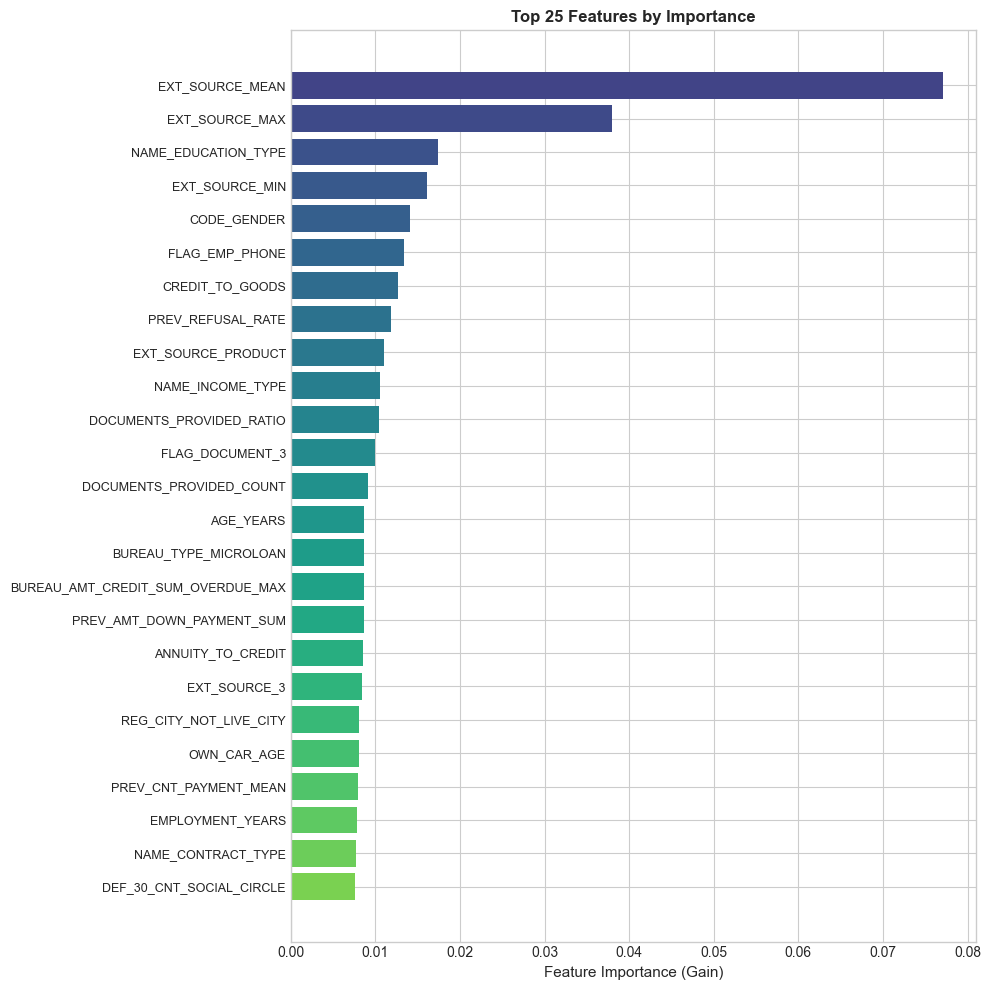


🔑 KEY INSIGHT: External source scores dominate, followed by engineered ratios


In [24]:
# code cell 19
# =============================================================================
# 7.2 VISUALIZE FEATURE IMPORTANCE
# =============================================================================

# Plot top 25 features
top_n = 25
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 10))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, top_n))
bars = ax.barh(range(top_n), top_features['importance'].values, color=colors)

ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values, fontsize=9)
ax.set_xlabel('Feature Importance (Gain)', fontsize=11)
ax.set_title(f'Top {top_n} Features by Importance', fontsize=12, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(REPORTS_PATH / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n🔑 KEY INSIGHT: External source scores dominate, followed by engineered ratios")

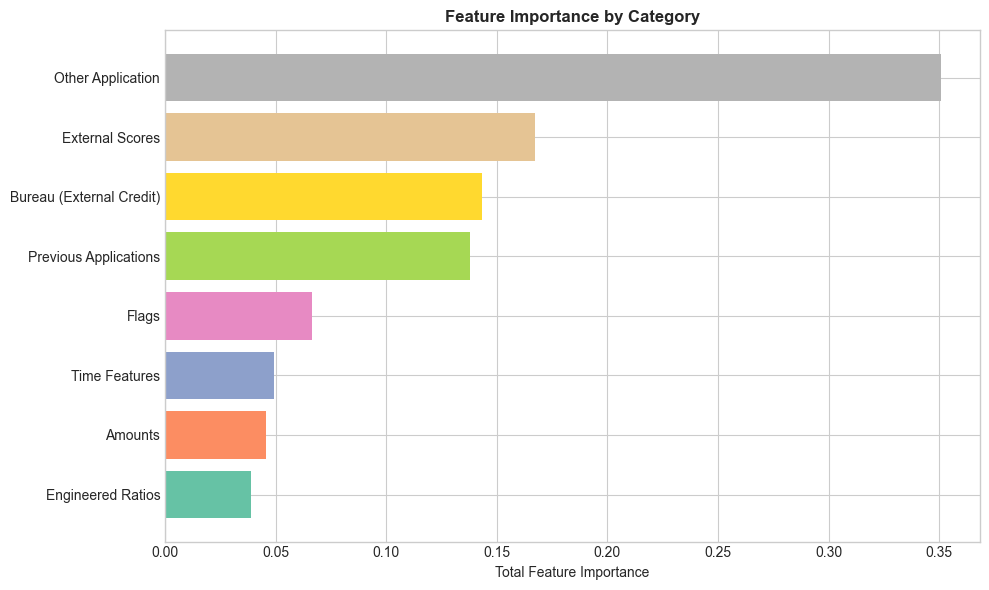


📊 Importance by Category:
category
Other Application           0.3509
External Scores             0.1674
Bureau (External Credit)    0.1435
Previous Applications       0.1381
Flags                       0.0663
Time Features               0.0493
Amounts                     0.0458
Engineered Ratios           0.0388
Name: importance, dtype: float32


In [25]:
# Code cell 20
# =============================================================================
# 7.3 FEATURE IMPORTANCE BY CATEGORY
# =============================================================================

# Categorize features
def categorize_feature(feature_name):
    if feature_name.startswith('BUREAU_'):
        return 'Bureau (External Credit)'
    elif feature_name.startswith('PREV_'):
        return 'Previous Applications'
    elif feature_name.startswith('EXT_SOURCE'):
        return 'External Scores'
    elif feature_name in ['DEBT_TO_INCOME', 'PAYMENT_BURDEN', 'CREDIT_TO_GOODS', 
                          'ANNUITY_TO_CREDIT', 'INCOME_PER_PERSON', 'INCOME_TO_CREDIT']:
        return 'Engineered Ratios'
    elif feature_name.startswith('FLAG_'):
        return 'Flags'
    elif feature_name.startswith('AMT_'):
        return 'Amounts'
    elif feature_name.startswith('DAYS_') or feature_name.endswith('_YEARS'):
        return 'Time Features'
    else:
        return 'Other Application'

importance_df['category'] = importance_df['feature'].apply(categorize_feature)

# Aggregate importance by category
category_importance = importance_df.groupby('category')['importance'].sum().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.Set2(np.linspace(0, 1, len(category_importance)))
bars = ax.barh(range(len(category_importance)), category_importance.values, color=colors)
ax.set_yticks(range(len(category_importance)))
ax.set_yticklabels(category_importance.index)
ax.set_xlabel('Total Feature Importance')
ax.set_title('Feature Importance by Category', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(REPORTS_PATH / 'feature_importance_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Importance by Category:")
print(category_importance.sort_values(ascending=False).round(4))

# 8. Model Calibration Check

For credit risk, we need **calibrated probabilities**. When our model predicts 30% probability of default, approximately 30% of those customers should actually default. This is essential for calculating Expected Loss accurately.

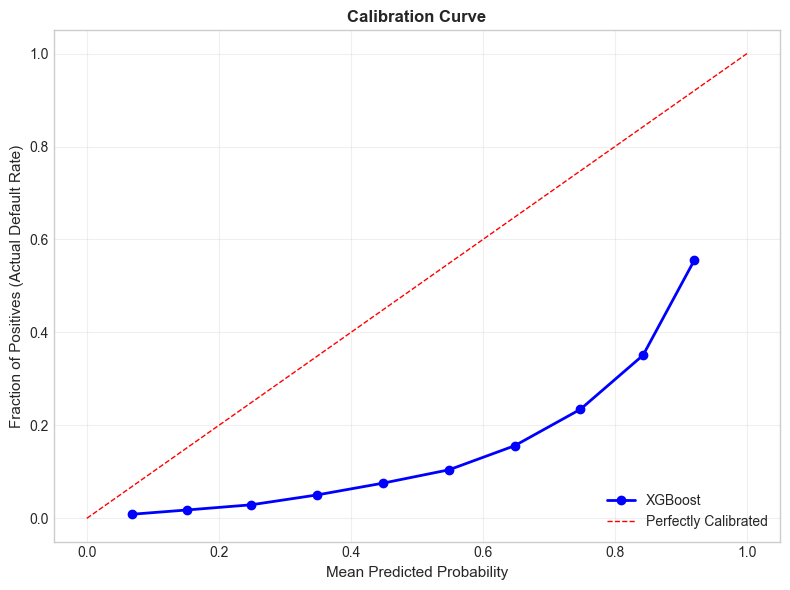

💡 INTERPRETATION:
   Points close to the diagonal = well-calibrated predictions
   Points above diagonal = model underestimates risk
   Points below diagonal = model overestimates risk


In [26]:
# Code cell 21
# =============================================================================
# 8.1 CALIBRATION CURVE
# =============================================================================

from sklearn.calibration import calibration_curve

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='uniform')

# Plot calibration curve
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(prob_pred, prob_true, 'bo-', linewidth=2, label='XGBoost')
ax.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Perfectly Calibrated')

ax.set_xlabel('Mean Predicted Probability', fontsize=11)
ax.set_ylabel('Fraction of Positives (Actual Default Rate)', fontsize=11)
ax.set_title('Calibration Curve', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_PATH / 'calibration_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("💡 INTERPRETATION:")
print("   Points close to the diagonal = well-calibrated predictions")
print("   Points above diagonal = model underestimates risk")
print("   Points below diagonal = model overestimates risk")

# 9. Save Final Model

In [27]:
# Code cell 22
# =============================================================================
# 9.1 SAVE MODEL AND ARTIFACTS
# =============================================================================

print("Saving model and artifacts...")

# Save the trained model
model_path = MODELS_PATH / 'xgb_credit_model.pkl'
joblib.dump(model_baseline, model_path)
print(f"✅ Model saved: {model_path}")

# Save label encoders for later use
encoders_path = MODELS_PATH / 'label_encoders.pkl'
joblib.dump(label_encoders, encoders_path)
print(f"✅ Label encoders saved: {encoders_path}")

# Save optimal thresholds
thresholds_info = {
    'statistical_optimal': optimal_threshold_youden,
    'business_optimal': optimal_threshold_business,
    'default': 0.5
}
joblib.dump(thresholds_info, MODELS_PATH / 'thresholds.pkl')
print(f"✅ Thresholds saved")

# Save feature names
feature_names_path = MODELS_PATH / 'feature_names.pkl'
joblib.dump(feature_cols, feature_names_path)
print(f"✅ Feature names saved")

print(f"\nAll artifacts saved to: {MODELS_PATH}")

Saving model and artifacts...
✅ Model saved: c:\Users\carlo\Documents\4.DS\credit-risk-early-warning-system\models\xgb_credit_model.pkl
✅ Label encoders saved: c:\Users\carlo\Documents\4.DS\credit-risk-early-warning-system\models\label_encoders.pkl
✅ Thresholds saved
✅ Feature names saved

All artifacts saved to: c:\Users\carlo\Documents\4.DS\credit-risk-early-warning-system\models


# 10. Summary and Next Steps

In [28]:
# Code cell 23
print("=" * 70)
print("MODEL TRAINING COMPLETE!")
print("=" * 70)

print(f"""
📊 MODEL PERFORMANCE:
   AUC-ROC:     {auc_score:.4f}
   Gini:        {gini:.4f}
   CV Mean AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})

📍 OPTIMAL THRESHOLDS:
   Statistical (Youden's J): {optimal_threshold_youden:.4f}
   Business (Max Profit):    {optimal_threshold_business:.4f}

🔑 TOP 5 FEATURES:
{importance_df.head(5).to_string(index=False)}

💾 SAVED ARTIFACTS:
   - Model:          models/xgb_credit_model.pkl
   - Encoders:       models/label_encoders.pkl
   - Thresholds:     models/thresholds.pkl
   - Feature names:  models/feature_names.pkl

📋 NEXT STEPS:
   1. SHAP analysis for explainability (Notebook 04)
   2. Build AI agent for risk monitoring
   3. Create Streamlit dashboard
   4. Deploy to production
""")

MODEL TRAINING COMPLETE!

📊 MODEL PERFORMANCE:
   AUC-ROC:     0.7793
   Gini:        0.5585
   CV Mean AUC: 0.7757 (±0.0037)

📍 OPTIMAL THRESHOLDS:
   Statistical (Youden's J): 0.5092
   Business (Max Profit):    0.5900

🔑 TOP 5 FEATURES:
            feature  importance          category
    EXT_SOURCE_MEAN    0.077107   External Scores
     EXT_SOURCE_MAX    0.038003   External Scores
NAME_EDUCATION_TYPE    0.017366 Other Application
     EXT_SOURCE_MIN    0.016061   External Scores
        CODE_GENDER    0.014057 Other Application

💾 SAVED ARTIFACTS:
   - Model:          models/xgb_credit_model.pkl
   - Encoders:       models/label_encoders.pkl
   - Thresholds:     models/thresholds.pkl
   - Feature names:  models/feature_names.pkl

📋 NEXT STEPS:
   1. SHAP analysis for explainability (Notebook 04)
   2. Build AI agent for risk monitoring
   3. Create Streamlit dashboard
   4. Deploy to production



---
**End of Notebook 03: Model Training**

Next: `04_explainability.ipynb` (SHAP Analysis)